## **<font color="red">RAG in LangGraph</font>**

In [1]:
from typing import TypedDict, Annotated, List

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.document_loaders import PyPDFLoader, UnstructuredPDFLoader, PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, BaseMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


| Model Name                  | Model ID        | Size   | Last Modified |
|----------------------------|-----------------|--------|---------------|
| mistral:7b                 | 6577803aa9a0    | 4.4 GB | 5 days ago    |
| smollm2:1.7b               | cef4a1e09247    | 1.8 GB | 5 days ago    |
| granite4:3b                | 89962fcc7523    | 2.1 GB | 5 days ago    |
| qwen2.5:3b                 | 357c53fb659c    | 1.9 GB | 6 days ago    |
| qwen3:4b                   | 359d7dd4bcda    | 2.5 GB | 6 days ago    |
| qwen3:1.7b                 | 8f68893c685c    | 1.4 GB | 6 days ago    |
| qwen3:0.6b                 | 7df6b6e09427    | 522 MB | 6 days ago    |
| gemma3:4b                  | a2af6cc3eb7f    | 3.3 GB | 10 days ago   |
| gemma3:1b                  | 8648f39daa8f    | 815 MB | 10 days ago   |
| llama3.2:3b                | a80c4f17acd5    | 2.0 GB | 2 weeks ago   |
| qwen3-embedding:4b         | df5bd2e3c74c    | 2.5 GB | 2 weeks ago   |
| qwen3-embedding:0.6b       | ac6da0dfba84    | 639 MB | 2 weeks ago   |
| mxbai-embed-large:335m     | 468836162de7    | 669 MB | 2 weeks ago   |
| nomic-embed-text:v1.5      | 0a109f422b47    | 274 MB | 2 weeks ago   |
| phi3:mini                  | 4f2222927938    | 2.2 GB | 3 weeks ago   |
| qwen2.5:0.5b               | a8b0c5157701    | 397 MB | 3 weeks ago   |
| llama3.2:1b                | baf6a787fdff    | 1.3 GB | 3 weeks ago   |
| llama3.1:8b                | 46e0c10c039e    | 4.9 GB | 3 weeks ago   |


In [2]:
# LLM Model
llm = ChatOllama(model="qwen2.5:3b",temperature=0.5)
llm

ChatOllama(model='qwen2.5:3b', temperature=0.5)

In [3]:
# Embedding Model
embedding = OllamaEmbeddings(model="nomic-embed-text:v1.5")
embedding

OllamaEmbeddings(model='nomic-embed-text:v1.5', validate_model_on_init=False, base_url=None, client_kwargs={}, async_client_kwargs={}, sync_client_kwargs={}, mirostat=None, mirostat_eta=None, mirostat_tau=None, num_ctx=None, num_gpu=None, keep_alive=None, num_thread=None, repeat_last_n=None, repeat_penalty=None, temperature=None, stop=None, tfs_z=None, top_k=None, top_p=None)

In [4]:
# Load the document
loader = PyPDFLoader("Intro2ML.pdf")
docs = loader.load()
print(len(docs))
docs[20]

234


Document(metadata={'producer': 'pdfTeX-1.40.10', 'creator': 'LaTeX with hyperref package', 'creationdate': '2010-10-01T15:47:05-07:00', 'author': 'AlexJ.SmolaandVishyS.V.N.Vishwanathan', 'title': 'AnIntroductiontoMachineLearning', 'subject': '', 'keywords': '', 'moddate': '2010-10-01T15:47:05-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-1.40.10-2.2 (TeX Live/MacPorts 2009_6) kpathsea version 5.0.0', 'source': 'Intro2ML.pdf', 'total_pages': 234, 'page': 20, 'page_label': '13'}, page_content='1.2 Probability Theory 13\nX take on a value +1 whenever the coin lands heads and a value of −1\notherwise. Our notational convention will be to use uppercase letters, e.g.,\nX, Y etc to denote random variables and lower case letters, e.g., x, y etc to\ndenote the values they take.\nX\nweight\nheight\nξ(x)\nx\nFig. 1.9. The random variable ξ maps from the set of outcomes of an experiment\n(denoted here by X) to real numbers. As an illustration here X consists of

In [5]:
# Chunking
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)
print(len(chunks))
chunks[50]

566


Document(metadata={'producer': 'pdfTeX-1.40.10', 'creator': 'LaTeX with hyperref package', 'creationdate': '2010-10-01T15:47:05-07:00', 'author': 'AlexJ.SmolaandVishyS.V.N.Vishwanathan', 'title': 'AnIntroductiontoMachineLearning', 'subject': '', 'keywords': '', 'moddate': '2010-10-01T15:47:05-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-1.40.10-2.2 (TeX Live/MacPorts 2009_6) kpathsea version 5.0.0', 'source': 'Intro2ML.pdf', 'total_pages': 234, 'page': 14, 'page_label': '7'}, page_content='by a vector of counts which describe the occurrence of words. The latter is\ncommonly referred to as bag of words features.\nOne of the challenges in dealing with vectors is that the scales and units\nof diﬀerent coordinates may vary widely. For instance, we could measure the\nheight in kilograms, pounds, grams, tons, stones, all of which would amount\nto multiplicative changes. Likewise, when representing temperatures, we\nhave a full class of aﬃne transformatio

In [6]:
# # Generate Embeddings
# vector_store = FAISS.from_documents(documents=chunks, embedding=embedding)
# save_directory = "./faiss_db_intro2ml"
# vector_store.save_local(save_directory)
# vector_store

# # Load Embeddings
# vector_store = FAISS.load_local(
#     folder_path="./faiss_db_intro2ml",
#     embeddings=embedding,
#     allow_dangerous_deserialization=True
# )
# vector_store

In [7]:
# Generate Embeddings
vector_store = FAISS.from_documents(documents=chunks, embedding=embedding)
vector_store

In [8]:
# Retriever
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k': 4})
retriever

VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001B0F5F6FA50>, search_kwargs={'k': 4})

In [9]:
# Test Retriever
retriever.invoke("What is a Decision Tree")

[Document(id='8cfc2700-87c3-4bee-9365-bda07be37c48', metadata={'producer': 'pdfTeX-1.40.10', 'creator': 'LaTeX with hyperref package', 'creationdate': '2010-10-01T15:47:05-07:00', 'author': 'AlexJ.SmolaandVishyS.V.N.Vishwanathan', 'title': 'AnIntroductiontoMachineLearning', 'subject': '', 'keywords': '', 'moddate': '2010-10-01T15:47:05-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-1.40.10-2.2 (TeX Live/MacPorts 2009_6) kpathsea version 5.0.0', 'source': 'Intro2ML.pdf', 'total_pages': 234, 'page': 0, 'page_label': 'i'}, page_content='INTRODUCTION TO MACHINE LEARNING'),
 Document(id='313be9d8-09c1-4720-a7c4-9100a368df5f', metadata={'producer': 'pdfTeX-1.40.10', 'creator': 'LaTeX with hyperref package', 'creationdate': '2010-10-01T15:47:05-07:00', 'author': 'AlexJ.SmolaandVishyS.V.N.Vishwanathan', 'title': 'AnIntroductiontoMachineLearning', 'subject': '', 'keywords': '', 'moddate': '2010-10-01T15:47:05-07:00', 'trapped': '/False', 'ptex.fullbanner': 'T

### **RAG Tool**

In [10]:
@tool
def rag_tool(query):
    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }


In [11]:
# Tool Binding with LLM
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)


In [24]:
# State
class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]


In [29]:
def chat_node(state: ChatState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [30]:
tool_node = ToolNode(tools)


| Condition result | Next node            |
| ---------------- | -------------------- |
| `"tools"`        | Go to `"tools"` node |
| `END`            | Stop the graph       |


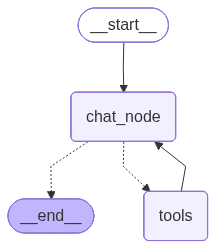

In [31]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
# Conditional routing
graph.add_conditional_edges(
    "chat_node",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile()

chatbot


In [32]:
result = chatbot.invoke(
    {
        "messages": [
        HumanMessage(
            content=(
                "Using the pdf notes, explain how to find the ideal value of K in KNN"
            )
        )]
    }
)
result

{'messages': [HumanMessage(content='Using the pdf notes, explain how to find the ideal value of K in KNN', additional_kwargs={}, response_metadata={}, id='5c67ae5f-339d-4b45-8125-6f46302c2747'),
  AIMessage(content='Finding the optimal value for \\(K\\) (the number of neighbors) in the k-Nearest Neighbors (k-NN) algorithm is an important step in ensuring good performance and avoiding overfitting or underfitting. Here’s a general approach to finding the ideal value of \\(K\\):\n\n### 1. Understand the Problem\nFirst, understand what you are trying to solve with your classification or regression problem. Is it a binary classification? A multi-class classification? What is the nature of the data (e.g., high-dimensional data)? Understanding these aspects will guide your choice.\n\n### 2. Consider the Data Characteristics\n- **High-Dimensional Data**: In higher dimensions, \\(K\\) tends to have a larger influence on the decision boundary because each feature contributes equally.\n- **Small 